In [3]:
%matplotlib inline
import numpy as np
np.random.seed(42) # fixing the seed
import matplotlib
import matplotlib.pyplot as plt
import rampy as rp
from scipy.stats import norm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

# ML classificator class

Below is the class I am working on, to wrap the scikit-learn algorithm in a similar way compared to the regression class:

In [4]:
class mlclassificator:
    """use machine learning algorithms from scikit learn to perform classification of spectra.
    
    Attributes
    ----------
    x : {array-like, sparse matrix}, shape = (n_samples, n_features)
        Spectra; n_features = n_frequencies.
    y : array, shape = (n_samples,)
        numeric labels.
    X_test : {array-like, sparse matrix}, shape = (n_samples, n_features)
        spectra organised in rows (1 row = one spectrum) that you want to use as a testing dataset. THose spectra should not be present in the x (training) dataset. The spectra should share a common X axis.
    y_test : array, shape = (n_samples,)
        numeric labels that you want to use as a testing dataset. Those targets should not be present in the y (training) dataset.
    algorithm : String,
        "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"  
    scaling : Bool
        True or False. If True, data will be scaled during fitting and prediction with the requested scaler (see below),
    scaler : String
        the type of scaling performed. Choose between MinMaxScaler or StandardScaler, see http://scikit-learn.org/stable/modules/preprocessing.html for details. Default = "MinMaxScaler".
    test_size : float
        the fraction of the dataset to use as a testing dataset; only used if X_test and y_test are not provided.
    rand_state : Float64
        the random seed that is used for reproductibility of the results. Default = 42.
    params_ : Dictionary
        contain the values of the hyperparameters that should be provided to the algorithm. See scikit-learn documentation for details for each algorithm.
    prediction_train : Array{Float64}
        the predicted target values for the training y dataset.
    prediction_test : Array{Float64}
        the predicted target values for the testing y_test dataset.
    model : Scikit learn model
        A Scikit Learn object model, see scikit learn library documentation.
    X_scaler :
        A Scikit Learn scaler object for the x values.
    Y_scaler :
        A Scikit Learn scaler object for the y values.
    
    Example
    -------
    Given an array X of n samples by m frequencies, and Y an array of n x 1 concentrations
    >>> model = rampy.mlclassificator(X,y)
    >>> model.algorithm("SVC")
    >>> model.user_kernel = 'poly'
    >>> model.fit()
    >>> y_new = model.predict(X_new)
    
    Remarks
    -------
    For details on hyperparameters of each algorithms, please directly consult the documentation of SciKit Learn at:
    http://scikit-learn.org/stable/
    
    In progress
    """

    def __init__(self,x,y,**kwargs):
        """
        Parameters
        ----------
        x : array{Float64}
            the spectra organised in rows (1 row = one spectrum). The spectra should share a common X axis.
        y : Array{Float64}
            Target. Only a single target is possible for now.
        """
        self.x = x
        self.y = y
        #
        # Kwargs extractions
        #
        self.X_test = kwargs.get("X_test",[0.0])
        self.y_test = kwargs.get("y_test",[0.0])
        self.algorithm = kwargs.get("algorithm","Nearest Neighbors")
        self.test_sz = kwargs.get("test_size",0.3)
        self.scaling = kwargs.get("scaling",True)
        self.scaler = kwargs.get("scaler","MinMaxScaler")
        self.rand_state = kwargs.get("rand_state",42)

        # hyperparameters for the algorithms
        self.user_kernel = kwargs.get("kernel","rbf")
        
        self.params_ = kwargs.get(
            "params_",None)

        if len(self.X_test) == 1:
            self.X_train, self.X_test, self.y_train, self.y_test = sklearn.model_selection.train_test_split(
            self.x, self.y.reshape(-1, 1), test_size=self.test_sz, random_state=self.rand_state)
        elif self.X_test.shape[1] == self.x.shape[1]:
            self.X_train = np.copy(self.x)
            self.y_train = np.copy(self.y)
        else:
            ValueError("You tried to provide a testing dataset that has a different number of features (in columns) than the training set. Please correct this.")

        # to avoid any problem with SciKit Learn quite annoying demands for the shape of arrays...
        self.y_train = self.y_train.reshape(-1,1)
        self.y_test = self.y_test.reshape(-1, 1)

        # initialising the preprocessor scaler
        if self.scaler == "StandardScaler":
            self.X_scaler = sklearn.preprocessing.StandardScaler()
        elif self.scaler == "MinMaxScaler":
            self.X_scaler = sklearn.preprocessing.MinMaxScaler()
        else:
            InputError("Choose the scaler between MinMaxScaler and StandardScaler")
            
            
        # now defining the model functions in a safe way:
        self.dispatcher = {"Nearest Neighbors" : KNeighborsClassifier(3), 
                      "Linear SVM" : SVC(kernel="linear", C=0.025),
                      "RBF SVM" : SVC(gamma=2, C=1),
                      "Gaussian Process" : GaussianProcessClassifier(),
                      "Decision Tree" : DecisionTreeClassifier(max_depth=15), 
                      "Random Forest" : RandomForestClassifier(max_depth=15, n_estimators=5, max_features=2), 
                      "Neural Net": MLPClassifier(),
                      "AdaBoost": AdaBoostClassifier(),
                      "Naive Bayes": GaussianNB(), 
                      "QDA": QuadraticDiscriminantAnalysis()}
                      
    def fit(self):
        """Scale data and train the model with the indicated algorithm.
        Do not forget to tune the hyperparameters.
        Parameters
        ----------
        algorithm : String,
            "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"
        """
        
        # scaling the data in all cases, it may not be used during the fit later
        self.X_scaler.fit(self.X_train)
        self.X_train_sc = self.X_scaler.transform(self.X_train)
        self.X_test_sc = self.X_scaler.transform(self.X_test)

        self.model = self.dispatcher[self.algorithm]
        
        if self.params_ != None:
            self.model(**self.params)
            #self.model = BaggingRegressor(base_estimator = nn_m, **self.param_bag)

        if self.scaling == True:
            self.model.fit(self.X_train_sc, self.y_train.reshape(-1,))
            self.prediction_train = self.model.predict(self.X_train_sc)
            self.prediction_test = self.model.predict(self.X_test_sc)
        else:
            self.model.fit(self.X_train, self.y_train.reshape(-1,))
            self.prediction_train = self.model.predict(self.X_train)
            self.prediction_test = self.model.predict(self.X_test)

    def refit(self):
        """Re-train a model previously trained with fit()
        """
        if self.scaling == True:
            self.model.fit(self.X_train_sc, self.y_train.reshape(-1,))
            self.prediction_train = self.model.predict(self.X_train_sc)
            self.prediction_test = self.model.predict(self.X_test_sc)
        else:
            self.model.fit(self.X_train, self.y_train.reshape(-1,))
            self.prediction_train = self.model.predict(self.X_train)
            self.prediction_test = self.model.predict(self.X_test)

    def predict(self,X):
        """Predict using the model.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = (n_samples, n_features)
            Samples.
        Returns
        -------
        C : array, shape = (n_samples,)
            Returns predicted values.
        Remark
        ------
        if self.scaling == "yes", scaling will be performed on the input X.
        """
        if self.scaling == True:
            X_sc = self.X_scaler.transform(X)
            return self.model.predict(X_sc)
        else:
            return self.model.predict(self.X)

# Fake data generation

Below we generate 5 fake signals that can be measured modulo some noise. More complex examples can be generated if wanted.

Number of samples = 100
Number of labels = 100


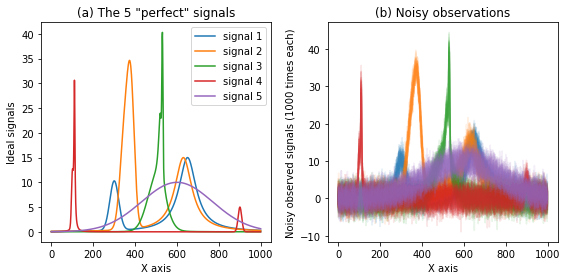

In [5]:
# The X axis
x = np.arange(0, 1000, 1.0)

# The perfect 5 signals
spectra_1 = rp.gaussian(x, 10.0, 300., 25.) + rp.lorentzian(x, 15., 650., 50.)
spectra_2 = rp.gaussian(x, 20.0, 350., 25.) + rp.gaussian(x, 25.0, 380., 20.) + rp.lorentzian(x, 15., 630., 50.)
spectra_3 = rp.gaussian(x, 10.0, 500., 50.) + rp.lorentzian(x, 15.0, 520., 10.) + rp.gaussian(x, 25., 530., 3.)
spectra_4 = rp.gaussian(x, 10.0, 100., 5.) + rp.lorentzian(x, 30.0, 110., 3.) + rp.gaussian(x, 5., 900., 10.)
spectra_5 = rp.gaussian(x, 10.0, 600., 200.)

# the number of observations of each signal
number_of_spectra = 20

# generating a dataset (will be shuffled later during the train-test split)
dataset = np.hstack((np.ones((len(x),number_of_spectra))*spectra_1.reshape(-1,1),
                     np.ones((len(x),number_of_spectra))*spectra_2.reshape(-1,1),
                     np.ones((len(x),number_of_spectra))*spectra_3.reshape(-1,1),
                     np.ones((len(x),number_of_spectra))*spectra_4.reshape(-1,1),
                     np.ones((len(x),number_of_spectra))*spectra_5.reshape(-1,1)
                    )).T

# add noise
noise_scale = 2.0
dataset = dataset + np.random.normal(scale=noise_scale,size=(len(dataset),len(x)))

# create numeric labels
labels =  np.vstack((np.tile(np.array([1]).reshape(-1,1),number_of_spectra),
                     np.tile(np.array([2]).reshape(-1,1),number_of_spectra),
                     np.tile(np.array([3]).reshape(-1,1),number_of_spectra),
                     np.tile(np.array([4]).reshape(-1,1),number_of_spectra),
                     np.tile(np.array([5]).reshape(-1,1),number_of_spectra),
                    )).reshape(-1,1)

print('Number of samples = {}'.format(dataset.shape[0]))
print('Number of labels = {}'.format(labels.shape[0]))

# Do figure
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title('(a) The 5 "perfect" signals')
plt.plot(x, spectra_1, label='signal 1')
plt.plot(x, spectra_2, label='signal 2')
plt.plot(x, spectra_3, label='signal 3')
plt.plot(x, spectra_4, label='signal 4')
plt.plot(x, spectra_5, label='signal 5')
plt.xlabel('X axis')
plt.ylabel('Ideal signals')
plt.legend()

plt.subplot(1,2,2)
plt.title('(b) Noisy observations')
plt.plot(x, dataset[0*number_of_spectra:1*number_of_spectra,:].T, color="C0",alpha=0.1)
plt.plot(x, dataset[1*number_of_spectra:2*number_of_spectra,:].T, color="C1",alpha=0.1)
plt.plot(x, dataset[2*number_of_spectra:3*number_of_spectra,:].T, color="C2",alpha=0.1)
plt.plot(x, dataset[3*number_of_spectra:4*number_of_spectra,:].T, color="C3",alpha=0.1)
plt.plot(x, dataset[4*number_of_spectra:5*number_of_spectra,:].T, color="C4",alpha=0.1)

plt.xlabel('X axis')
plt.ylabel('Noisy observed signals (1000 times each)')

plt.tight_layout()

# Machine Learning example of treatment

This is using directly the scikit-learn functions

In [6]:
X = dataset
y = labels

# shufling
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

#
# TRain/Test split
#

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#
# Initiate classifiers
#

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(max_depth=15),
    RandomForestClassifier(max_depth=15, n_estimators=5, max_features=2),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(), QuadraticDiscriminantAnalysis()]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train.ravel())
    score = clf.score(X_test, y_test.ravel())
    print('\n- Classifier:'+name+' is scoring '+str(score)+'.')


- Classifier:Nearest Neighbors is scoring 1.0.

- Classifier:Linear SVM is scoring 1.0.

- Classifier:RBF SVM is scoring 0.09090909090909091.

- Classifier:Gaussian Process is scoring 0.09090909090909091.

- Classifier:Decision Tree is scoring 0.8787878787878788.

- Classifier:Random Forest is scoring 0.8484848484848485.

- Classifier:Neural Net is scoring 1.0.

- Classifier:AdaBoost is scoring 1.0.

- Classifier:Naive Bayes is scoring 1.0.

- Classifier:QDA is scoring 0.5454545454545454.


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# ML classification with rampy

This does the exact same thing as above, using the rampy class.

In [7]:
# initiate model
MLC = mlclassificator(X,y,scaling=False,test_size=0.33)

# iterate over classifiers
for name in names:
    MLC.algorithm = name
    MLC.fit()
    score = MLC.model.score(MLC.X_test, MLC.y_test)
    print('\n- Classifier:'+name+' is scoring (test:) '+str(score)+'.')


- Classifier:Nearest Neighbors is scoring (test:) 1.0.

- Classifier:Linear SVM is scoring (test:) 1.0.

- Classifier:RBF SVM is scoring (test:) 0.09090909090909091.

- Classifier:Gaussian Process is scoring (test:) 0.09090909090909091.

- Classifier:Decision Tree is scoring (test:) 0.8787878787878788.

- Classifier:Random Forest is scoring (test:) 1.0.

- Classifier:Neural Net is scoring (test:) 1.0.

- Classifier:AdaBoost is scoring (test:) 0.9696969696969697.

- Classifier:Naive Bayes is scoring (test:) 1.0.

- Classifier:QDA is scoring (test:) 0.5454545454545454.


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
